### EBM의 변수별 기여도를 바탕으로 한 feature engineering 확인
- 데이터의 변화에 따른 정확도를 확인하기 위해 모델 파라미터는 러프하게 진행
- 기존 변수들의 모델링을 통한 정확도와 EBM을 통한 feature engineering 후의 정확도를 비교


#### 데이터 설명 
- [Download Link]
    - https://www.kaggle.com/competitions/bike-sharing-demand/data
- [목적]
    - Forecast use of a city bikeshare system (자전거 공유 수요량 예측)
- [특징]
    - 2년 동안의 시간당 데이터로 구성됨
    - Target 변수를 포함하여 총 12개의 변수로 구성됨
    - 대여 기간 전에 사용할 수 있는 정보만 활용하여 테스트 세트에서 다루는 각 시간 동안 대여한 총 자전거 수 예측
- [train data]
    - 매월 1일부터 19일까지의 데이터
- [test data]
    - 20일부터 월말까지의 데이터

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import *
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
# 데이터 불러오기 및 확인
df = pd.read_csv('data/bike_train.csv')

# datetime 변수 유형 변경
df.datetime = pd.to_datetime(df.datetime)

print(df.shape)
df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
X = df.drop(['datetime','count'], axis=1)
y = df['count']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print('학습데이터 크기:', x_train.shape)
print('평가데이터 크기:', x_test.shape)

학습데이터 크기: (8708, 10)
평가데이터 크기: (2178, 10)


----

### EBM 적용

In [9]:
from interpret import show
from interpret.glassbox import ExplainableBoostingRegressor
from interpret.data import Marginal # 설명 시각화를 렌더링하기 위한 역할
from sklearn.metrics import mean_squared_error

ebm = ExplainableBoostingRegressor(random_state=42, n_jobs=1)
ebm.fit(x_train, y_train)

ExplainableBoostingRegressor(feature_names=['season', 'holiday', 'workingday',
                                            'weather', 'temp', 'atemp',
                                            'humidity', 'windspeed', 'casual',
                                            'registered', 'temp x registered',
                                            'casual x registered',
                                            'atemp x registered',
                                            'season x registered',
                                            'humidity x registered',
                                            'humidity x casual',
                                            'windspeed x registered',
                                            'season x temp',
                                            'windspeed x casual',
                                            'workingday x registered'],
                             feature_types=['continuous', 'categorical',
               

In [17]:
ebm_pred = ebm.predict(x_test)
ebm_pred

array([129.337413  ,  12.10013928, 160.25173689, ..., 505.79549857,
         4.72320247, 238.12106604])

In [19]:
RMSE = mean_squared_error(y_test, ebm_pred)**0.5
RMSE

3.4995113210641438

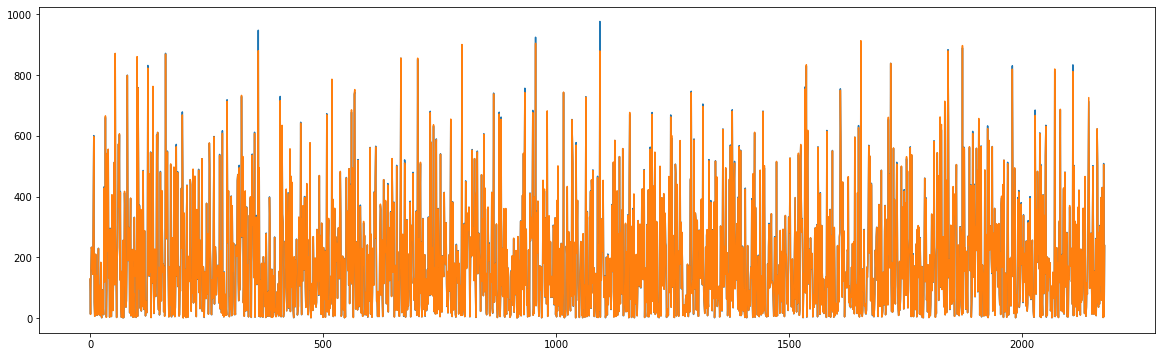

In [23]:
plt.figure(figsize = (20,6))
plt.plot(np.array(y_test))
plt.plot(ebm_pred)
plt.show()

### Explanation
1. global explain
2. local explain

In [11]:
## Global Explanation
    # Partial Dependent Plot(PDP)와 히스토그램
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\interpret\visual\udash.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\interpret\visual\udash.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\interpret\visual\udash.py:7: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table as dt


<!-- http://127.0.0.1:7001/1687249644168/ -->

[해석]
- 'registered'와 'casual' 변수가 count의 상승에 가장 큰 영향을 미침 -> 다른 변수들과의 차이가 심함
- 'registered'
    - (0~42.9)가 대부분
    - 값이 커질수록 count 간에 양의 추세가 존재 -> score의 분산 크지 않음
    - 범주 구성: (0~150), (150~350), (350~550), (550, 750), (750~)

- 'casual'
    - 변수의 경우 (0~17.2)까지가 대부분이며 69 이후부터는 거의 없음
    - 값이 커질수록 count는 완만한 양의 추세를 가짐-> score의 분산 크지 않음
    - 범주 구성: (0~100, 100~200, 200~300, 300~)

In [53]:
## Local expain
    # 자차가 제일 작은 관측치 20개와 큰 관측치 20개에 대해서 비교
result = pd.DataFrame({'pred':ebm_pred, 'real':np.array(y_test), 'resid':np.abs(np.array(y_test)-ebm_pred).round(2)})
top_index = result.sort_values('resid').head(20).index.to_list()
low_index = result.sort_values('resid').tail(20).index.to_list()
result.head()

,pred,real,resid
0,129.337413,127,2.34
1,12.100139,13,0.90
2,160.251737,163,2.75
3,233.200095,233,0.20
4,222.627660,222,0.63


In [54]:
# 잔차가 가장 낮은 10개 관측치에 대한 explain
ebm_local_top = ebm.explain_local(x_test.iloc[top_index,:], result.loc[top_index, 'real'], name='EBM')
show(ebm_local_top)

<!-- http://127.0.0.1:7001/1687361232392/ -->

- real 값이 매우 큰 관측치들은 존재하지 않음 => 실제값이 작을 때 예측을 더 잘한다.
- 'registered'의 기여도가 제일 높긴 하지만, 'casual'도 적지 않음
- 예측을 잘 하는 관측치(real 값이 작은 경우)들은 'registered'와 'actual'은 negative contribution을 갖는 경우가 많음 -> intercept의 영향력을 줄이기 위함

In [55]:
# 잔차가 가장 낮은 10개 관측치에 대한 explain
ebm_local_low = ebm.explain_local(x_test.iloc[low_index,:], result.loc[low_index, 'real'], name='EBM')
show(ebm_local_low)

<!-- http://127.0.0.1:7001/1687361725896/ -->

- real 값이 매우 큰 경우가 다반사
- 대부분의 관측치가 registered에만 상당히 의존하고 있음
- real 값이 큰 관측치 예측에서는 영향력이 큰 두 변수 모두 positive contribution을 가지고 있음

---

1. Feature contribution을 기반으로, 'registered', 'casual' 두 연속형 변수의 파생(범주형) 변수를 생성하고자 한다.
2. 간단한 모델링을 통해 확인한 결과, 예측을 잘 못하는 경우는 real 값이 큰 경우이다.
3. `두 개 변수에서 값이 큰 관측치들의 범주를 보다 디테일하게 나눈다면 성능이 오르지 않을까?` => 실험 내용

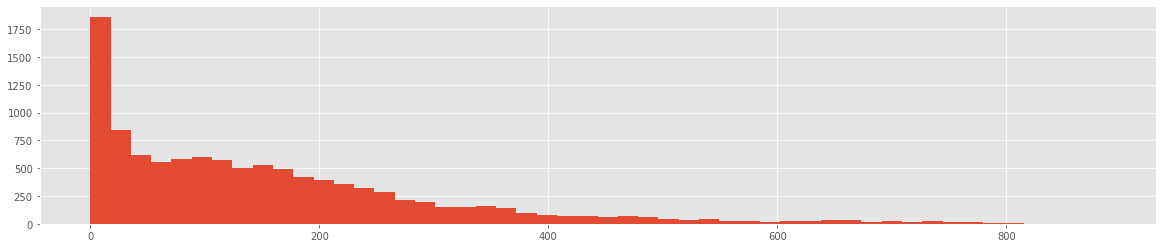

In [61]:
# registered 변수 나누기
df['registered'].hist(figsize = (20,4), bins=50)

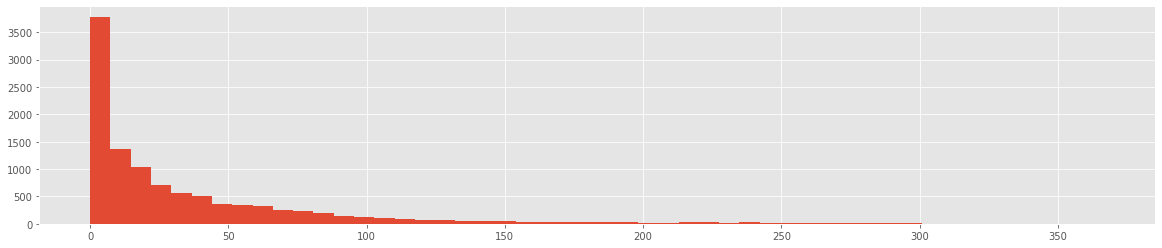

In [84]:
# casual 변수 나누기
df['casual'].hist(figsize = (20,4), bins=50)

In [82]:
for qq in np.arange(0.9,1, 0.02):
    print(f'{qq}:', df['registered'].quantile(qq))

0.9: 354.0
0.92: 384.2000000000007
0.9400000000000001: 434.0
0.9600000000000001: 494.6000000000022
0.9800000000000001: 622.3000000000011


In [106]:
for qq in np.arange(0.9,1, 0.05):
    print(f'{qq}:', df['casual'].quantile(qq))

0.9: 94.0
0.9500000000000001: 141.0


In [131]:
df['registered_bin'] = pd.qcut(df['registered'], q=[0, 0.9, 0.93, 0.96, 0.98, 0.99, 0.995, 1], labels=[str(i) for i in range(7)])
df['casual_bin'] = pd.qcut(df['casual'], q=[0, 0.9, 0.93, 0.96, 0.98, 0.99, 0.995, 1], labels=[str(i) for i in range(7)])

In [132]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'registered_bin', 'casual_bin'],
      dtype='object')

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        10886 non-null  datetime64[ns]
 1   season          10886 non-null  int64         
 2   holiday         10886 non-null  int64         
 3   workingday      10886 non-null  int64         
 4   weather         10886 non-null  int64         
 5   temp            10886 non-null  float64       
 6   atemp           10886 non-null  float64       
 7   humidity        10886 non-null  int64         
 8   windspeed       10886 non-null  float64       
 9   casual          10886 non-null  int64         
 10  registered      10886 non-null  int64         
 11  count           10886 non-null  int64         
 12  registered_bin  10886 non-null  category      
 13  casual_bin      10886 non-null  category      
dtypes: category(2), datetime64[ns](1), float64(3), int64(8

In [121]:
df.registered_bin.value_counts()

0    9801
1     327
2     322
3     218
4     112
6      54
5      52
Name: registered_bin, dtype: int64

In [135]:
X = df.drop(['datetime','count'], axis=1)
y = df['count']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print('학습데이터 크기:', x_train.shape)
print('평가데이터 크기:', x_test.shape)

학습데이터 크기: (8708, 12)
평가데이터 크기: (2178, 12)


In [136]:
ebm_ex = ExplainableBoostingRegressor(random_state=42, n_jobs=1)
ebm_ex.fit(x_train, y_train)

ExplainableBoostingRegressor(feature_names=['season', 'holiday', 'workingday',
                                            'weather', 'temp', 'atemp',
                                            'humidity', 'windspeed', 'casual',
                                            'registered', 'registered_bin',
                                            'casual_bin',
                                            'temp x registered_bin',
                                            'atemp x registered_bin',
                                            'humidity x registered_bin',
                                            'season x registered_bin',
                                            'casual x registered_bin',
                                            'windspeed x registered',
                                            'windspeed x registered_bin',
                                            'atem...
                                            'temp x registered',
                    

In [137]:
ebm_pred_ex = ebm_ex.predict(x_test)
ebm_pred_ex

array([128.54012536,  12.00038075, 159.36979498, ..., 511.5400419 ,
         3.47217634, 240.70772744])

In [138]:
RMSE_ex = mean_squared_error(y_test, ebm_pred_ex)**0.5
RMSE_ex

4.4258181031367645

In [126]:
result_ex = pd.DataFrame({'pred_ex':ebm_pred_ex, 'pred':ebm_pred, 'real':np.array(y_test), 
                'resid':np.abs(np.array(y_test)-ebm_pred).round(2), 'resid_ex':np.abs(np.array(y_test)-ebm_pred_ex).round(2)})

top_index_ex = result_ex.sort_values('resid').head(20).index.to_list()
low_index_ex = result_ex.sort_values('resid').tail(20).index.to_list()
result_ex.head()

,pred_ex,pred,real,resid,resid_ex
0,128.483135,129.337413,127,2.34,1.48
1,12.019776,12.100139,13,0.90,0.98
2,159.380942,160.251737,163,2.75,3.62
3,233.458278,233.200095,233,0.20,0.46
4,223.193636,222.627660,222,0.63,1.19


In [116]:
result_ex.sort_values('resid_ex', ascending=False)

,pred_ex,pred,real,resid,resid_ex
1094,882.648280,879.916453,977,97.08,94.35
361,879.544646,880.659080,948,67.34,68.46
1654,921.280242,913.554805,888,25.55,33.28
325,697.008227,733.489759,730,3.49,32.99
798,909.093104,901.089888,877,24.09,32.09
...,...,...,...,...,...
1603,14.004710,13.452633,14,0.55,0.00
1439,82.001327,82.262776,82,0.26,0.00
170,167.999072,168.153071,168,0.15,0.00
380,6.004535,6.577580,6,0.58,0.00


In [139]:
## Global Explanation
ebm_global_ex = ebm_ex.explain_global(name='EBM')
show(ebm_global_ex)

<!-- http://127.0.0.1:7001/1687324156296/ -->

In [149]:
# 잔차가 가장 낮은 10개 관측치에 대한 explain
ebm_local_top = ebm_ex.explain_local(x_test.iloc[top_index,:], result.loc[top_index, 'real'], name='EBM')
show(ebm_local_top)

<!-- http://127.0.0.1:7001/1686979302984/ -->

----

In [143]:
df['registered_bin'] = pd.qcut(df['registered'], q=4, labels=[i for i in range(4)])
df['casual_bin'] = pd.qcut(df['casual'], q=4, labels=[i for i in range(4)])

In [144]:
X = df.drop(['datetime','count'], axis=1)
y = df['count']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print('학습데이터 크기:', x_train.shape)
print('평가데이터 크기:', x_test.shape)

학습데이터 크기: (8708, 12)
평가데이터 크기: (2178, 12)


In [145]:
ebm_ex2 = ExplainableBoostingRegressor(random_state=42, n_jobs=1)
ebm_ex2.fit(x_train, y_train)

ExplainableBoostingRegressor(feature_names=['season', 'holiday', 'workingday',
                                            'weather', 'temp', 'atemp',
                                            'humidity', 'windspeed', 'casual',
                                            'registered', 'registered_bin',
                                            'casual_bin', 'temp x registered',
                                            'atemp x registered',
                                            'casual x registered',
                                            'humidity x registered',
                                            'season x registered',
                                            'humidity x registered_bin',
                                            'season x temp', 'temp x humidity',
                                            'temp x registered_bin',
                                            'windspeed x registered_bin'],
                             feature_types=['cont

In [146]:
ebm_pred_ex2 = ebm_ex2.predict(x_test)
ebm_pred_ex2

array([127.93898038,  12.3045033 , 161.91271055, ..., 507.70085981,
         5.27804409, 238.97205438])

In [147]:
RMSE_ex = mean_squared_error(y_test, ebm_pred_ex)**0.5
RMSE_ex

4.4258181031367645